<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
import pickle
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
# We are going to convert [0..255] to [-1,1] and as a result we will use tanh() activation for Generator
STATS = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5) # means and stds for each channel, as a result we

In [ ]:
def get_dataloader(data_dir, image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(*STATS)
   ]))

  dataloader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dataloader

In [ ]:
def show_images(images, nmax=16,*, denorm = True, nrow = 4):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    if denorm:
        imgs = denormalize(images.detach()[:nmax])
    else:
        imgs = images.detach()[:nmax]
    ax.imshow(make_grid(imgs, nrow=nrow).permute(1, 2, 0))

def show_batch(dl, nmax=16, denorm = True):
    for images, _ in dl:
        assert nmax <= len(images), "Number of images exceeds batch size"
        show_images(images, nmax, denorm = denorm)
        break

In [ ]:
def denormalize(img_tensors):
    for ch in range(3):
        if img_tensors.shape[0] == 1:
            img_tensors[:,ch,:,:] = img_tensors[:,ch,:,:]*STATS[0][ch] + STATS[1][ch]
        else:
            img_tensors[ch,:,:] = img_tensors[ch,:,:]*STATS[0][ch] + STATS[1][ch]
    return img_tensors

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


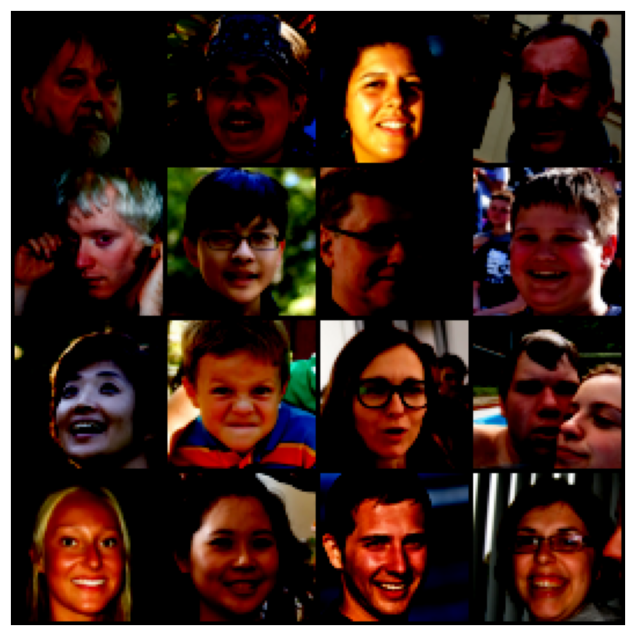

In [ ]:
train_dataloader = get_dataloader("/kaggle/input/faces-dataset-small", 64, 32)
# нормализованные фото
show_batch(train_dataloader, denorm = False)

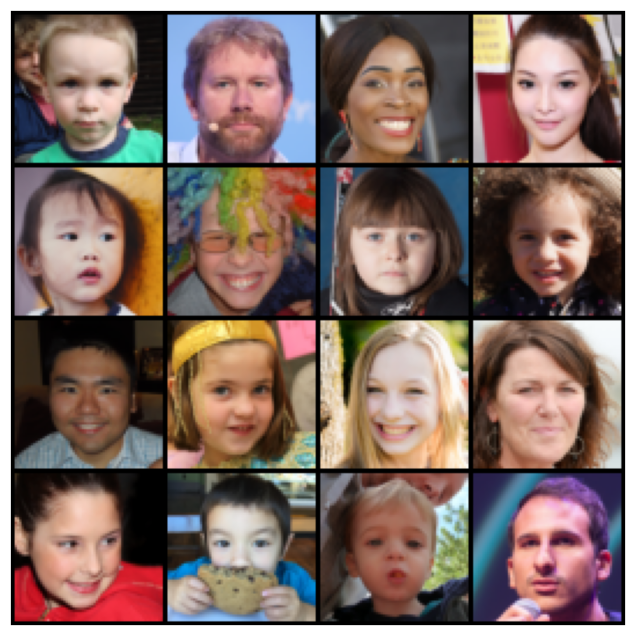

In [ ]:
#  оригинальные фото
show_batch(train_dataloader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
img_sz= 64 # размер картинки
z_dim = 64 # размерность латентного пространства

In [ ]:
def gen_block(in_dimension, out_dimension, stride = 2, padding = 1):
    block = nn.Sequential( nn.ConvTranspose2d(in_dimension, out_dimension, kernel_size=4, stride=stride, padding=padding),
        nn.BatchNorm2d(out_dimension),
        nn.LeakyReLU(0.2, inplace = True)
    )
    return block


generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.Conv2d(z_dim, 128, kernel_size = 1, stride=1, padding=0),
    # 128 x 1 x 1
    gen_block(128, 512, stride = 1, padding = 0),
    # out: 512 x 4 x 4
    gen_block(512, 256),
    # out: 256 x 8 x 8
    gen_block(256, 128),
    # out: 128 x 16 x 16
    gen_block(128, 64),
    # out: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
    nn.Tanh() # using htan because images are normalized [0..255] -> [-1..1]
    # out: 3 x 64 x 64
)

In [ ]:
from torchinfo import summary
summary(generator,input_size=(32, 64, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 3, 64, 64]           --
├─Conv2d: 1-1                            [32, 128, 1, 1]           8,320
├─Sequential: 1-2                        [32, 512, 4, 4]           --
│    └─ConvTranspose2d: 2-1              [32, 512, 4, 4]           1,049,088
│    └─BatchNorm2d: 2-2                  [32, 512, 4, 4]           1,024
│    └─LeakyReLU: 2-3                    [32, 512, 4, 4]           --
├─Sequential: 1-3                        [32, 256, 8, 8]           --
│    └─ConvTranspose2d: 2-4              [32, 256, 8, 8]           2,097,408
│    └─BatchNorm2d: 2-5                  [32, 256, 8, 8]           512
│    └─LeakyReLU: 2-6                    [32, 256, 8, 8]           --
├─Sequential: 1-4                        [32, 128, 16, 16]         --
│    └─ConvTranspose2d: 2-7              [32, 128, 16, 16]         524,416
│    └─BatchNorm2d: 2-8                  [32, 128, 16, 16] 

In [ ]:
def disc_block(in_dimension, out_dimension):
    block = nn.Sequential(
        nn.Conv2d(in_dimension, out_dimension, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d( out_dimension),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return block
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    disc_block(3, 64),
    # out: 64 x 32 x 32
    disc_block(64, 128),
    # out: 128 x 16 x 16
    disc_block(128, 256),
    # out: 256 x 8 x 8
    disc_block(256, 512),
    # out: 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
from torchinfo import summary
summary(discriminator, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          3,136
│    └─BatchNorm2d: 2-2                  [32, 64, 32, 32]          128
│    └─LeakyReLU: 2-3                    [32, 64, 32, 32]          --
├─Sequential: 1-2                        [32, 128, 16, 16]         --
│    └─Conv2d: 2-4                       [32, 128, 16, 16]         131,200
│    └─BatchNorm2d: 2-5                  [32, 128, 16, 16]         256
│    └─LeakyReLU: 2-6                    [32, 128, 16, 16]         --
├─Sequential: 1-3                        [32, 256, 8, 8]           --
│    └─Conv2d: 2-7                       [32, 256, 8, 8]           524,544
│    └─BatchNorm2d: 2-8                  [32, 256, 8, 8]           512
│    └─LeakyReLU: 2-9                    [32, 256, 8, 8]           --

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
models = {
    "discriminator": discriminator,
    "generator": generator
}

# Два лосса, каждый будет иметь свой граф вычисления для backpropagation
criterions = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizers = {           # сделаем скорость обучения дискриминатора меньше, т.к. у него проще задача, чем у генератора
    "discriminator": torch.optim.Adam(models["discriminator"].parameters(), lr=0.0002, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(models["generator"].parameters(), lr=0.0015, betas=(0.5, 0.999))
}


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# smoothing class=1 to [0.7, 1.0]
def smooth_positive_labels(y):
    return y - 0.3 + torch.rand(y.size(), device=DEVICE) * 0.3

#smoothing class=0 to [0.0, 0.3]
def smooth_negative_labels(y):
    return y +  torch.rand(y.size(), device=DEVICE)* 0.3

# сохраняем модель
def save_model(models, optims, log_name):
    torch.save({
        'g_model_state_dict': models["generator"].state_dict(),
        'd_model_state_dict': models["discriminator"].state_dict(),
        'g_ptimizer_state_dict': optims["generator"].state_dict(),
        'd_ptimizer_state_dict': optims["discriminator"].state_dict()
        }, log_name + ".pt"
    )

def fit(model, criterion, optimizer, epochs, dataloader, log_name):
    model["discriminator"].to(DEVICE)
    model["generator"].to(DEVICE)
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    latent_size = 64

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):

            # TRAIN DISCRIMINATOR
            batch_size = len(real_images)
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images.to(DEVICE))
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            sm_real_targets = smooth_positive_labels(real_targets)
            real_loss = criterion["discriminator"](real_preds, sm_real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=DEVICE)
            sm_fake_targets = smooth_negative_labels(fake_targets)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, sm_fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # TRAIN GENERATOR
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=DEVICE)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Show generated images
        with torch.no_grad():
            latent = torch.randn(10, latent_size, 1, 1, device=DEVICE)
            gen_images = model["generator"](latent)
            show_images(gen_images.cpu(), nmax = 10, nrow = 10)
            plt.show()


    # сохраняем кривые обучения для отчёта
    history = [losses_g, losses_d, real_scores, fake_scores]
    with open(log_name + ".pickle", 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # cохраняем модель
    save_model(model, optimizer, log_name)
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
learning_log = fit(models, criterions, optimizers, 80, train_dataloader, "DCGAN_80epochs")

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
with open("/kaggle/working/DCGAN_80epochs.pickle", 'rb') as log:
    learning_log = pickle.load(log)


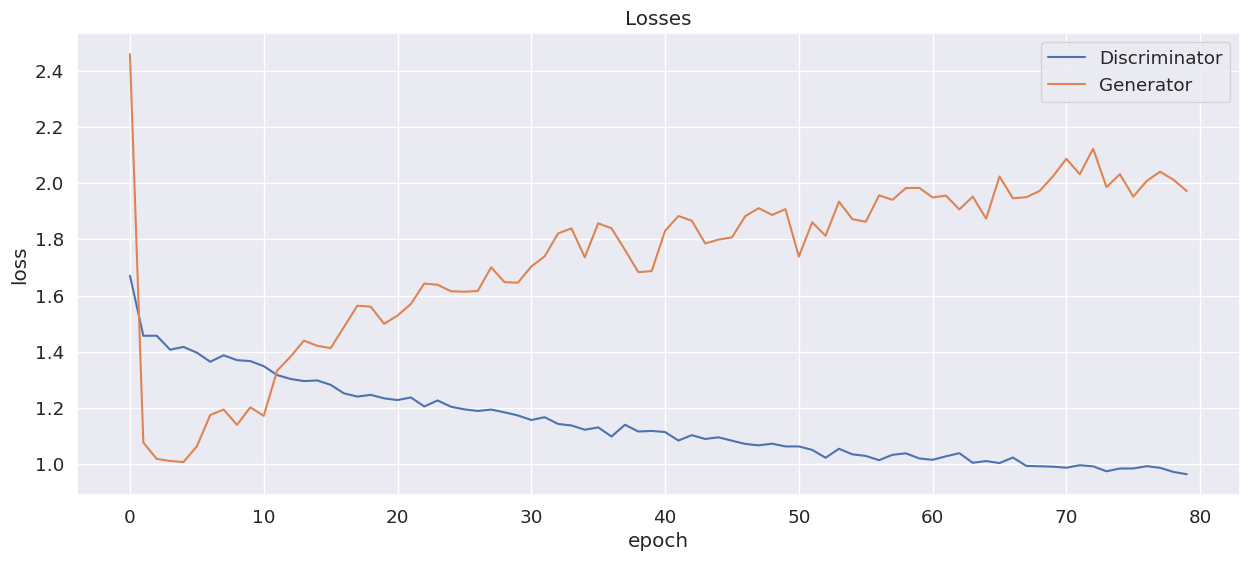

In [ ]:
# Loss
plt.figure(figsize=(15, 6))
plt.plot(learning_log[1], '-')
plt.plot(learning_log[0], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

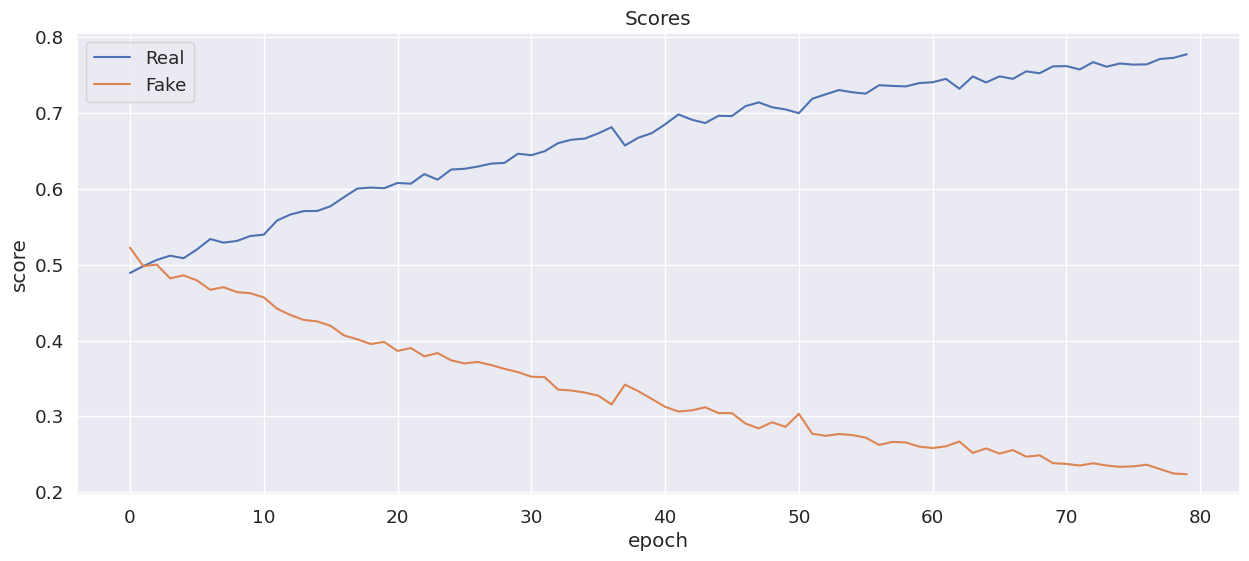

In [ ]:
# Scores
plt.figure(figsize=(15, 6))
plt.plot(learning_log[2], '-')
plt.plot(learning_log[3], '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Из кривых выше видно, что можно ещё дообучить модель, но сделав это ещё на 40 эпохах возникает model collapse, т.е. генератор

In [ ]:
checkpoint = torch.load("/kaggle/input/model80/DCGAN_80epochs.pt", map_location=DEVICE)

models["generator"].load_state_dict(checkpoint['g_model_state_dict'])
models["discriminator"].load_state_dict(checkpoint['d_model_state_dict'])
optimizers["generator"].load_state_dict(checkpoint['g_ptimizer_state_dict'])
optimizers["discriminator"].load_state_dict(checkpoint['d_ptimizer_state_dict'])

In [ ]:
learning_log1 = fit(models, criterions, optimizers, 40, train_dataloader, "DCGAN_40epochs")

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

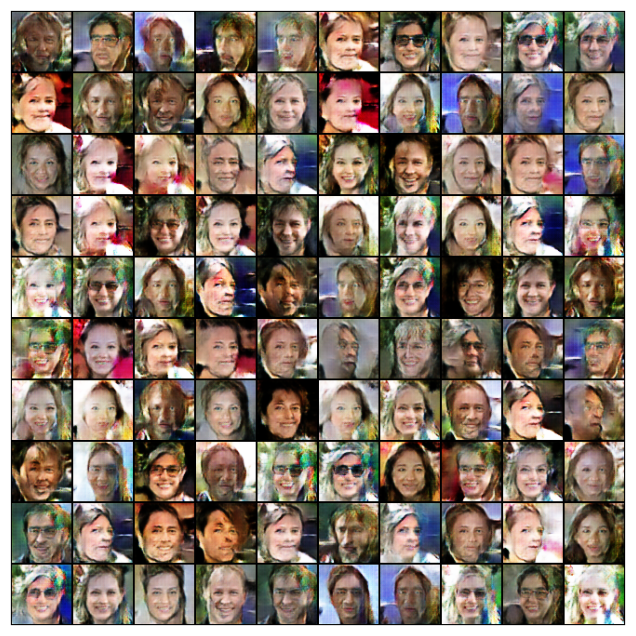

In [ ]:
# Show generated images
with torch.no_grad():
    latent_size = 64
    num_img = 100
    latent = torch.randn(num_img, latent_size, 1, 1, device=DEVICE)
    gen_images = models["generator"](latent)
    show_images(gen_images.cpu(), nmax = num_img, nrow = 10)
    plt.show()

Как вам качество получившихся изображений?
Неплохо для простой модельки.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Будем получать embeddings из ResNet50

In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights


# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
# model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s] 


In [ ]:
#  найдём эмбеддинги оригинальных картинок
real_embed = np.zeros((len(train_dataloader.dataset),1000))
for i, (img, _) in enumerate(train_dataloader.dataset):
    embedding = model(preprocess(denormalize(img)).unsqueeze(0)).squeeze(0).detach().numpy()
    real_embed[i] = embedding

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
with open("real_embed" + ".pickle", 'wb') as handle:
    pickle.dump(real_embed, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Generated fake images
with torch.no_grad():
    latent_size = 64
    num_img = len(train_dataloader.dataset)
    latent = torch.randn(num_img, latent_size, 1, 1, device=DEVICE)
    gen_images = models["generator"](latent)

In [ ]:
#  найдём эмбеддинги cгенерированных картинок
fake_embed = np.zeros((len(gen_images),1000))
for i, img in enumerate(gen_images):
    embedding = model(preprocess(denormalize(img)).unsqueeze(0)).squeeze(0).detach().numpy()
    fake_embed[i] = embedding

In [ ]:
with open("fake_embed" + ".pickle", 'wb') as handle:
    pickle.dump(fake_embed, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

loo = LeaveOneOut()
X = np.concatenate((real_embed, fake_embed))
Y = np.concatenate((np.ones(len(real_embed), dtype = int), np.zeros(len(fake_embed), dtype = int)))
accuracy = np.zeros(len(Y))
for i, (train_index, test_index) in enumerate(tqdm(loo.split(X), total=len(X))):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X[train_index], Y[train_index])
    accuracy[i] = accuracy_score(Y[test_index], knn.predict(X[test_index]))

0it [00:00, ?it/s]

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

In [ ]:
print(f"Average accuracy of leave-one-out knn: {np.mean(accuracy)}")

Average accuracy of leave-one-out knn: 0.6675151129494113


Accuracy достаточно близок к 0.5, т.е. knn классификатор плохо различает сгенерированные и реальные картинки, что хорошо

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
img_embed_tsne = tsne.fit_transform(X)

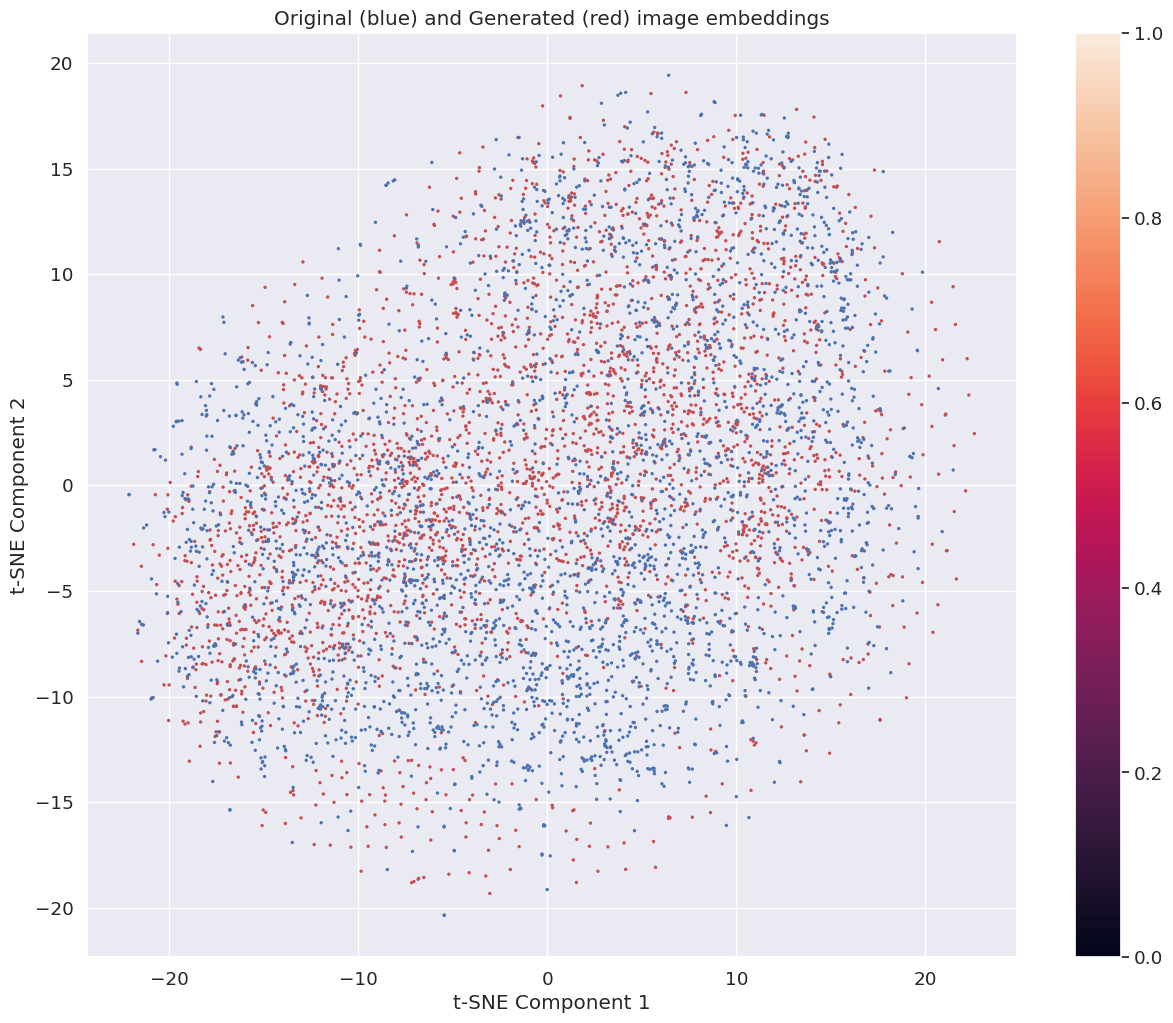

In [ ]:
# Plotting with Matplotlib
plt.figure(figsize=(15, 12))
colormap = np.array(['b', 'r'])
scatter = plt.scatter(img_embed_tsne[:,0], img_embed_tsne[:,1], c = colormap[Y], s=2)
plt.colorbar(scatter)
plt.title('Original (blue) and Generated (red) image embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Прокомментируйте получившийся результат:

Видно что эмбеддинги генерированных изображений (красные точки), выходят в некоторых местах за границы синего облака, также есть участки синего облака неплотного покрытые красными точками

### Посмотрим для интереса примерную размерность многообразия  1000-ом пространстве embedding-ов в котором лежат наши лица используя PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/Machine Learning/MIPT_Sem_1/GAN/HW/real_embed.pickle", 'rb') as real:
      z_vecs = pickle.load(real)

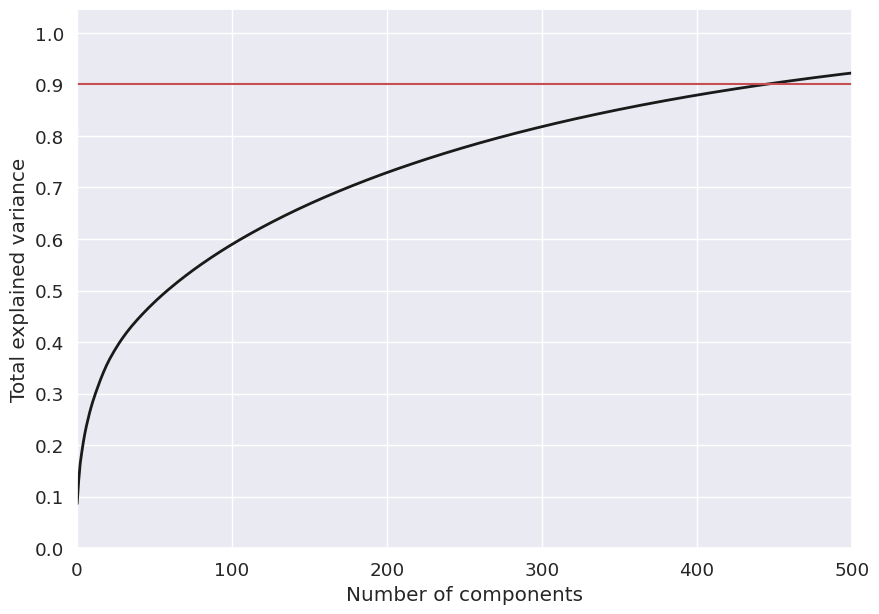

In [ ]:
# dimensionality reduction, т.к. данные лежат в некотором подмногообразии 200 мерного пространства
from sklearn.decomposition import PCA
center = z_vecs.mean(axis = 0) # центрируем облако перед PCA
z_vecs -= center
pca = PCA().fit(z_vecs)
# Из графика видно, чтобы объяснить 90% вариации данных в 200 мерном пространстве, достаточно взять 55 главных компонент
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 500)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')
plt.show()

Видно что основная информация хранитьсяв многообразии размерности 500 в 1000-ом пространстве